# Analysis of Historical Plane Crashes.

## Introduction

Air travel is widely regarded as one of the safest modes of transportation today, but understanding the historical trends in aviation accidents provides valuable insight into how safety has evolved over time. This analysis explores plane crashes across more than a century, examining patterns in fatalities, survival rates, aircraft types, operators, and geographical distribution.

The goal is to identify key trends in aviation safety, highlight the most lethal aircraft and accidents, and reveal how major historical events have shaped aviation risk. By combining quantitative metrics (like survival rate and fatality ratio) with descriptive insights from accident summaries, this study provides a comprehensive overview of what makes air travel historically risky and how safety improvements have reduced accidents over time.

## Dataset and Setup

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [122]:
df=pd.read_csv('Airplane_Crashes_Since_1908.csv')
df.columns=df.columns.str.lower()
df.head()

,date,time,location,operator,flight #,route,ac type,registration,cn/ln,aboard,aboard passangers,aboard crew,fatalities,fatalities passangers,fatalities crew,ground,summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,09/07/1909,NaN,"Juvisy-sur-Orge, France",NaN,NaN,Air show,Wright Byplane,SC1,NaN,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...
2,07/12/1912,06:30,"Atlantic City, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
3,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,NaN,NaN,Curtiss seaplane,NaN,NaN,1.0,0.0,1.0,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...
4,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,NaN,NaN,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...


## Data Cleaning

### Extracting City and Country From the Location Field

- The original dataset stored city and country together inside one column called location, which made analysis harder. To fix this, I created a function that splits each entry into two separate columns: city and country.

- To correctly identify U.S. locations, I first defined a list of all U.S. states. If the last part of the location matches a state name, it is labeled as United States. Otherwise, the last part is assumed to be the country name.

In [123]:
US_STATES = {
    "Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut","Delaware",
    "Florida","Georgia","Hawaii","Idaho","Illinois","Indiana","Iowa","Kansas","Kentucky",
    "Louisiana","Maine","Maryland","Massachusetts","Michigan","Minnesota","Mississippi",
    "Missouri","Montana","Nebraska","Nevada","New Hampshire","New Jersey","New Mexico",
    "New York","North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
    "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah","Vermont",
    "Virginia","Washington","West Virginia","Wisconsin","Wyoming"
}

In [124]:
def split_loc(location):
    if pd.isna(location):
        return pd.Series([None, None])

    parts = [p.strip() for p in location.split(",")]

    # US state as last element
    if parts[-1] in US_STATES:
        city = ", ".join(parts[:-1])
        country = "United States"
        return pd.Series([city, country])

    # last part is country, others form city
    city = ", ".join(parts[:-1])
    country = parts[-1]

    return pd.Series([city, country])

df[["city", "country"]] = df["location"].apply(split_loc)
df = df.drop(columns=["location"])

In [125]:
df.head()

,date,time,operator,flight #,route,ac type,registration,cn/ln,aboard,aboard passangers,aboard crew,fatalities,fatalities passangers,fatalities crew,ground,summary,city,country
0,09/17/1908,17:18,Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly...",Fort Myer,United States
1,09/07/1909,NaN,NaN,NaN,Air show,Wright Byplane,SC1,NaN,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...,Juvisy-sur-Orge,France
2,07/12/1912,06:30,Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...,Atlantic City,United States
3,08/06/1913,NaN,Private,NaN,NaN,Curtiss seaplane,NaN,NaN,1.0,0.0,1.0,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...,"Victoria, British Columbia",Canada
4,09/09/1913,18:30,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,NaN,NaN,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...,,Over the North Sea


### Renaming Columns for Clarity

- Some of the original column names were inconsistent, abbreviated, or hard to understand. To make the dataset easier to work with, I renamed several columns to clear, descriptive names.

In [126]:
df=df.rename(columns={'flight #':'flight_id',
                   'ac type':'aircraft_type',
                   'cn/ln':'construction_line',
                   'aboard':'total_aboard',
                  'aboard passangers':'passengers_abroad',
                  'aboard crew':'crew_aboard',
                  'fatalities passangers':'fatalities_passangers',
                  'fatalities crew':'fatalities_crew',
                  'summary':'accident_summary'})

df.head()

,date,time,operator,flight_id,route,aircraft_type,registration,construction_line,total_aboard,passengers_abroad,crew_aboard,fatalities,fatalities_passangers,fatalities_crew,ground,accident_summary,city,country
0,09/17/1908,17:18,Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly...",Fort Myer,United States
1,09/07/1909,NaN,NaN,NaN,Air show,Wright Byplane,SC1,NaN,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...,Juvisy-sur-Orge,France
2,07/12/1912,06:30,Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...,Atlantic City,United States
3,08/06/1913,NaN,Private,NaN,NaN,Curtiss seaplane,NaN,NaN,1.0,0.0,1.0,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...,"Victoria, British Columbia",Canada
4,09/09/1913,18:30,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,NaN,NaN,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...,,Over the North Sea


### Dropping unnecessary columns


- Some columns in the dataset, like registration and construction_line, contained mostly technical details that are not essential for our analysis. To keep the dataset clean and focused, I removed these columns. This simplifies the data and helps us concentrate on the most relevant information for studying airplane accidents.

- The code also checks that each column exists before trying to drop it, avoiding errors.

In [127]:
cols_to_drop = ["registration", "construction_line"] 
cols_present_to_drop = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=cols_present_to_drop)
print("Dropped:", cols_present_to_drop)
df.columns.tolist()

Dropped: ['registration', 'construction_line']


['date',
 'time',
 'operator',
 'flight_id',
 'route',
 'aircraft_type',
 'total_aboard',
 'passengers_abroad',
 'crew_aboard',
 'fatalities',
 'fatalities_passangers',
 'fatalities_crew',
 'ground',
 'accident_summary',
 'city',
 'country']

### Converting Dates and Extracting Year & Decade

- The dataset’s date column was originally stored as text, which makes it hard to analyze trends over time. First, I converted it to a proper datetime format. Any invalid dates were removed to ensure accuracy.

Next, I extracted two new columns:

- year – the exact year of each accident

- decade – the rounded decade (1990, 2000), which makes it easier to study long-term trends

In [139]:
df['date'] = pd.to_datetime(df['date'], errors='coerce') 

df['year'] = df['date'].dt.year
df['decade'] = (df['year'] // 10) * 10
df[['date','year','decade']].head()

,date,year,decade
0,1908-09-17,1908,1900
1,1909-09-07,1909,1900
2,1912-07-12,1912,1910
3,1913-08-06,1913,1910
4,1913-09-09,1913,1910


### Cleaning and Converting Numeric Columns

- Several columns in the dataset represent counts of people, such as passengers, crew, and fatalities. These columns sometimes contained missing or non-numeric values.


- All values were converted to numeric type.

- Missing values were replaced with 0, because if a count is missing, it likely means none were recorded.

- All counts are now stored as integers.

In [141]:
numeric_cols = [
    "total_aboard", "passengers_abroad", "crew_aboard",
    "fatalities", "fatalities_passangers", "fatalities_crew", "ground"
]

for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')   
        df[c] = df[c].fillna(0).astype(int)             

# check
df[numeric_cols].dtypes
df[numeric_cols].head()

,total_aboard,passengers_abroad,crew_aboard,fatalities,fatalities_passangers,fatalities_crew,ground
0,2,1,1,1,1,0,0
1,1,0,1,1,0,0,0
2,5,0,5,5,0,5,0
3,1,0,1,1,0,1,0
4,20,0,0,14,0,0,0


### Correcting Inconsistent Total Counts

- Sometimes the total_aboard column was recorded as 0, even though the sum of passengers and crew was greater than zero. This would cause errors in analyses like survival rate calculations.



- I calculated a temporary computed_total by adding passengers and crew.

- Wherever total_aboard was 0 but computed_total was greater than 0, I replaced it with the correct total.

- The temporary column was then removed to keep the dataset clean.

In [142]:
# if total_aboard is zero but passengers_aboard + crew_aboard > 0 fix it
mask = (df['total_aboard'] == 0) & (('passengers_aboard' in df.columns) and (df['passengers_aboard'] + df['crew_aboard'] > 0))
# safer- compute a new_total where sum exists
df['computed_total'] = 0
if 'passengers_aboard' in df.columns and 'crew_aboard' in df.columns:
    df['computed_total'] = df['passengers_aboard'] + df['crew_aboard']

# if total_aboard is 0 but computed_total > 0 replace it
df.loc[(df['total_aboard'] == 0) & (df['computed_total'] > 0), 'total_aboard'] = df['computed_total']

# dropping helper column
df = df.drop(columns=['computed_total'])

### Create survival_rate and fatality_ratio features

To better understand the severity of each accident, I created two new columns:

- survival_rate – the proportion of people onboard who survived

- fatality_ratio – the proportion of people who died

To avoid errors, I only calculated these ratios when total_aboard > 0. Missing or zero totals are set as NaN.

Both columns are rounded to 4 decimal places for clarity. Using these metrics we can compare accidents not just by fatalities, but also how deadly they were relative to the number of people onboard.

In [144]:
df['survival_rate'] = np.where(
    df['total_aboard'] > 0,
    1 - (df['fatalities'] / df['total_aboard']),
    np.nan
)

df['fatality_ratio'] = np.where(
    df['total_aboard'] > 0,
    df['fatalities'] / df['total_aboard'],
    np.nan
)

df['survival_rate'] = df['survival_rate'].astype(float).round(4)
df['fatality_ratio'] = df['fatality_ratio'].astype(float).round(4)


df['survival_rate'] = df['survival_rate'].astype(float)
df['fatality_ratio'] = df['fatality_ratio'].astype(float)


df[['total_aboard','fatalities','survival_rate','fatality_ratio']].head()

,total_aboard,fatalities,survival_rate,fatality_ratio
0,2,1,0.5,0.5
1,1,1,0.0,1.0
2,5,5,0.0,1.0
3,1,1,0.0,1.0
4,20,14,0.3,0.7


### Identifying military flights and summary availability

To add more context to the dataset, I created two boolean columns:

- is_military – indicates whether the flight was operated by a military organization. This is determined by checking if the word “military” appears in the operator name.

- has_summary – shows whether an accident has a written summary. This helps us know which records have detailed descriptions for further text analysis.

In [145]:
df['is_military'] = df['operator'].str.contains('military', case=False, na=False)
df['has_summary'] = df['accident_summary'].notna() & df['accident_summary'].str.strip().ne("")
df[['operator','is_military','has_summary']].head(10)

,operator,is_military,has_summary
0,Military - U.S. Army,True,True
1,NaN,False,True
2,Military - U.S. Navy,True,True
3,Private,False,True
4,Military - German Navy,True,True
5,Military - German Navy,True,True
6,Military - German Navy,True,True
7,Military - German Navy,True,True
8,Military - German Army,True,True
9,Military - German Navy,True,True


### Removing records with missing essential information

To ensure reliable analysis, I removed rows that were missing critical information:

- Every record must have a valid date.

- Each record must have at least a country or an operator listed.

Rows that didn’t meet these criteria were dropped.

In [147]:
initial_len = len(df)

# keep rows where date exists and (country / operator exists)
mask_keep = df['date'].notna() & ((df['country'].notna() & df['country'].str.strip().ne('')) | (df['operator'].notna() & df['operator'].str.strip().ne('')))

df = df[mask_keep].copy()
print(f"Dropped {initial_len - len(df)} rows that lacked essential info")
df.info()

Dropped 0 rows that lacked essential info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4967 entries, 0 to 4966
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   4967 non-null   datetime64[ns]
 1   city                   4963 non-null   object        
 2   country                4963 non-null   object        
 3   operator               4957 non-null   object        
 4   aircraft_type          4952 non-null   object        
 5   total_aboard           4967 non-null   int32         
 6   passengers_abroad      4967 non-null   int32         
 7   crew_aboard            4967 non-null   int32         
 8   fatalities             4967 non-null   int32         
 9   fatalities_passangers  4967 non-null   int32         
 10  fatalities_crew        4967 non-null   int32         
 11  ground                 4967 non-null   int32         
 12  accident_summary    

### Drop low-value columns

Some columns in the dataset, like flight_id, time, and route, either had too many missing values or were not essential for our analysis.

In [134]:
df.drop(columns=['flight_id', 'time', 'route'], inplace=True)
df.head()

,date,operator,aircraft_type,total_aboard,passengers_abroad,crew_aboard,fatalities,fatalities_passangers,fatalities_crew,ground,accident_summary,city,country,year,decade,survival_rate,fatality_ratio,is_military,has_summary
0,1908-09-17,Military - U.S. Army,Wright Flyer III,2,1,1,1,1,0,0,"During a demonstration flight, a U.S. Army fly...",Fort Myer,United States,1908,1900,0.5,0.5,True,True
1,1909-09-07,NaN,Wright Byplane,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...,Juvisy-sur-Orge,France,1909,1900,0.0,1.0,False,True
2,1912-07-12,Military - U.S. Navy,Dirigible,5,0,5,5,0,5,0,First U.S. dirigible Akron exploded just offsh...,Atlantic City,United States,1912,1910,0.0,1.0,True,True
3,1913-08-06,Private,Curtiss seaplane,1,0,1,1,0,1,0,The first fatal airplane accident in Canada oc...,"Victoria, British Columbia",Canada,1913,1910,0.0,1.0,False,True
4,1913-09-09,Military - German Navy,Zeppelin L-1 (airship),20,0,0,14,0,0,0,The airship flew into a thunderstorm and encou...,,Over the North Sea,1913,1910,0.3,0.7,True,True


### Move non-country entries to “Unknown”.

Some entries in the country column were not actual countries (e.g., “Over the North Sea”, “At sea”) or were missing.

To standardize the dataset, these values were replaced with Unknown, making it easier to analyze crashes by country without confusing or inconsistent entries.

In [135]:
invalid_countries = [
    'Over the North Sea', 'At sea', 'Sea', 'In flight', '', 'Unknown'
]

df['country'] = df['country'].replace(invalid_countries, 'Unknown')

In [148]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4967 entries, 0 to 4966
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   4967 non-null   datetime64[ns]
 1   city                   4963 non-null   object        
 2   country                4963 non-null   object        
 3   operator               4957 non-null   object        
 4   aircraft_type          4952 non-null   object        
 5   total_aboard           4967 non-null   int32         
 6   passengers_abroad      4967 non-null   int32         
 7   crew_aboard            4967 non-null   int32         
 8   fatalities             4967 non-null   int32         
 9   fatalities_passangers  4967 non-null   int32         
 10  fatalities_crew        4967 non-null   int32         
 11  ground                 4967 non-null   int32         
 12  accident_summary       4903 non-null   object        
 13  has

### Reordering Columns for Clarity

To make the dataset more intuitive and easier to read, I reordered the columns into a logical sequence:

- 1. Date & location – when and where the accident happened

- 2. Operator & aircraft info – who operated the flight and what type of aircraft it was

- 3. People onboard – total passengers and crew

- 4. Fatalities – number of deaths onboard and on the ground

- 5. Summary & metadata – accident description, year, decade, survival metrics, and whether the flight was military


In [137]:
ordered_columns = [
    'date',
    'city',
    'country',
    'operator',
    'aircraft_type',
    'total_aboard',
    'passengers_abroad',
    'crew_aboard',
    'fatalities',
    'fatalities_passangers',
    'fatalities_crew',
    'ground',
    'accident_summary',
    'has_summary',
    'year',
    'decade',
    'survival_rate',
    'fatality_ratio',
    'is_military'
]

df = df[ordered_columns]

df.head()

,date,city,country,operator,aircraft_type,total_aboard,passengers_abroad,crew_aboard,fatalities,fatalities_passangers,fatalities_crew,ground,accident_summary,has_summary,year,decade,survival_rate,fatality_ratio,is_military
0,1908-09-17,Fort Myer,United States,Military - U.S. Army,Wright Flyer III,2,1,1,1,1,0,0,"During a demonstration flight, a U.S. Army fly...",True,1908,1900,0.5,0.5,True
1,1909-09-07,Juvisy-sur-Orge,France,NaN,Wright Byplane,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...,True,1909,1900,0.0,1.0,False
2,1912-07-12,Atlantic City,United States,Military - U.S. Navy,Dirigible,5,0,5,5,0,5,0,First U.S. dirigible Akron exploded just offsh...,True,1912,1910,0.0,1.0,True
3,1913-08-06,"Victoria, British Columbia",Canada,Private,Curtiss seaplane,1,0,1,1,0,1,0,The first fatal airplane accident in Canada oc...,True,1913,1910,0.0,1.0,False
4,1913-09-09,,Unknown,Military - German Navy,Zeppelin L-1 (airship),20,0,0,14,0,0,0,The airship flew into a thunderstorm and encou...,True,1913,1910,0.3,0.7,True


### Saving the Cleaned Dataset

After completing all the cleaning, renaming, and reordering steps, I saved the final dataset to a new CSV file called plane_crashes_cleaned.csv.

In [149]:
df.to_csv("plane_crashes_cleaned.csv", index=False)

## Exploratory Data Analysis (EDA)

- We now explore trends, fatalities, and survival rates over time

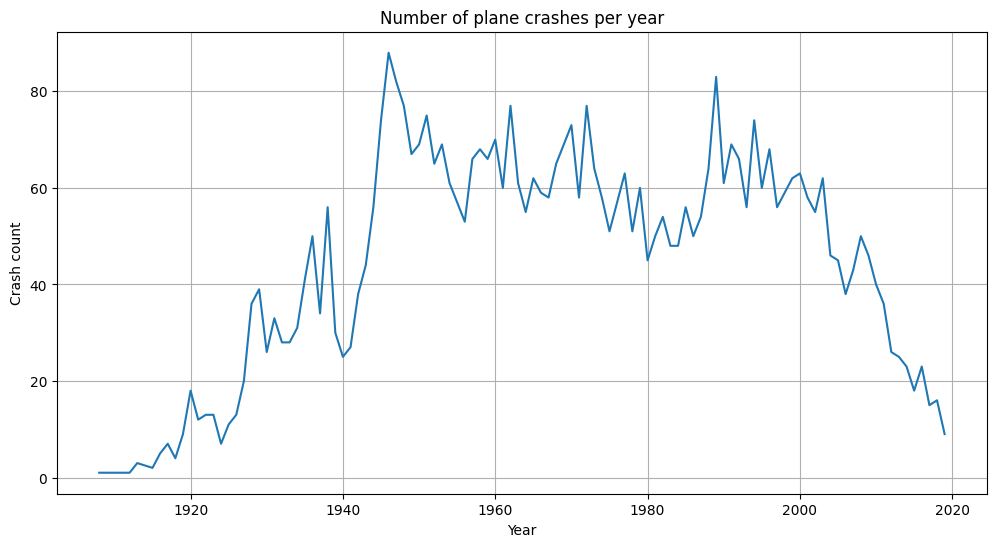

In [151]:
crashes_per_year = df.groupby("year").size()

plt.figure(figsize=(12,6))
crashes_per_year.plot()
plt.title("Number of plane crashes per year")
plt.xlabel("Year")
plt.ylabel("Crash count")
plt.grid(True)
plt.show()

- Similar to fatalities, the number of crashes has drastically decreased since the early 2000s, suggesting a major, recent success in aviation safety and accident prevention.

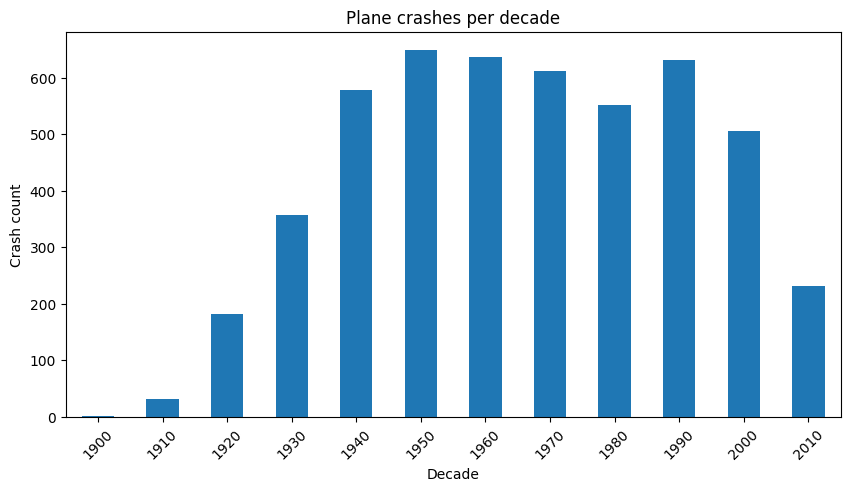

In [156]:
crashes_per_decade = df.groupby("decade").size()

plt.figure(figsize=(10,5))
crashes_per_decade.plot(kind="bar")
plt.title("Plane crashes per decade")
plt.xlabel("Decade")
plt.ylabel("Crash count")
plt.xticks(rotation=45)
plt.show()

- The 1950s was the peak decade for the sheer number of crashes (over 650), while the 2010s show the lowest crash count since the 1930s, reinforcing the trend of improving modern safety.

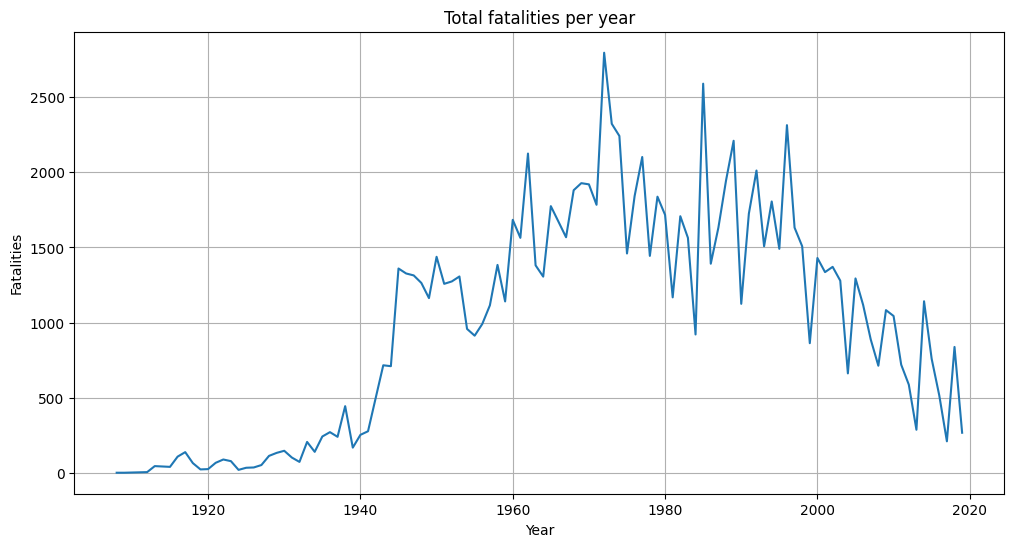

In [157]:
fatalities_per_year = df.groupby("year")["fatalities"].sum()

plt.figure(figsize=(12,6))
fatalities_per_year.plot()
plt.title("Total fatalities per year")
plt.xlabel("Year")
plt.ylabel("Fatalities")
plt.grid(True)
plt.show()

- Annual fatalities spiked significantly in the 1940s (likely due to WWII) and remained highly volatile until a clear, consistent decline started after the year 2000, indicating much safer air travel today.

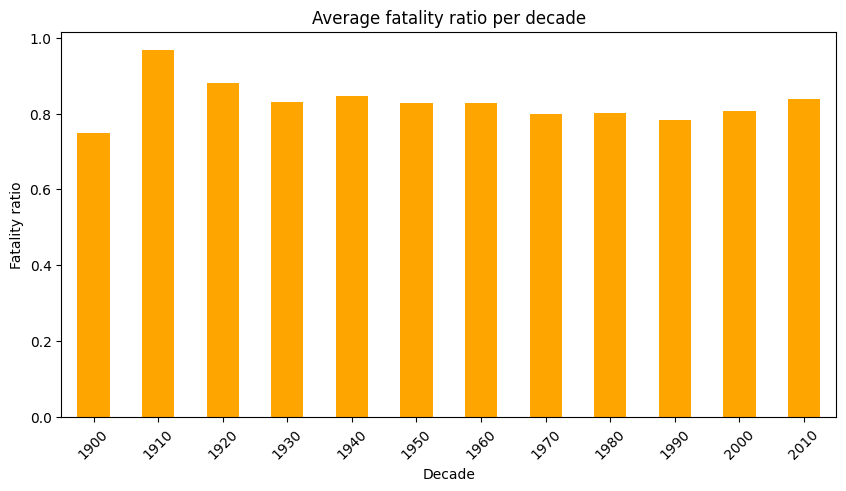

In [155]:
fatality_ratio_decade = df.groupby("decade")["fatality_ratio"].mean()

plt.figure(figsize=(10,5))
fatality_ratio_decade.plot(kind="bar", color="orange")
plt.title("Average fatality ratio per decade")
plt.xlabel("Decade")
plt.ylabel("Fatality ratio")
plt.xticks(rotation=45)
plt.show()


- The fatality ratio has been consistently and severely high (above 0.80 or 80%) since the 1930s, emphasizing that when an air crash does occur, the event is overwhelmingly likely to be fatal.

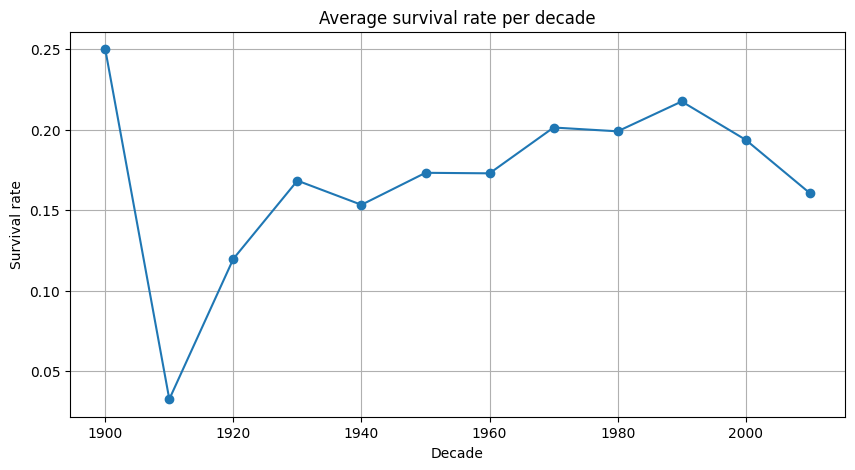

In [158]:
survival_by_decade = df.groupby("decade")["survival_rate"].mean()

plt.figure(figsize=(10,5))
survival_by_decade.plot(kind="line", marker="o")
plt.title("Average survival rate per decade")
plt.xlabel("Decade")
plt.ylabel("Survival rate")
plt.grid(True)
plt.show()

- Despite high crash numbers in mid-century, the survival rate showed a general positive trend, peaking in the 1990s (around 22%), suggesting improvements in aircraft design (e.g., fire safety, structure) that made crashes more survivable.

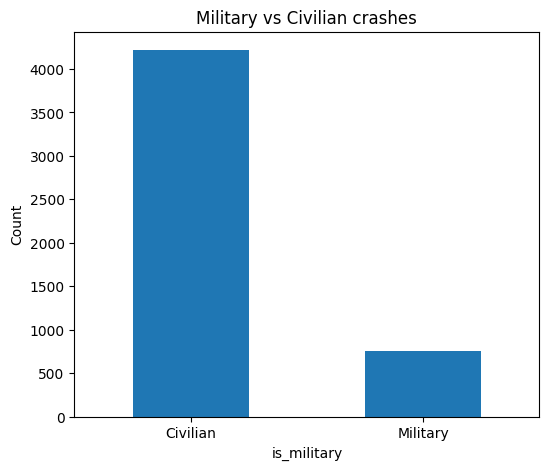

In [160]:
military_counts = df["is_military"].value_counts()

plt.figure(figsize=(6,5))
military_counts.plot(kind="bar")
plt.title("Military vs Civilian crashes")
plt.xticks([0,1], ["Civilian", "Military"], rotation=0)
plt.ylabel("Count")
plt.show()

- Civilian aircraft crashes vastly outnumber Military crashes (roughly 4 to 1), which is expected due to the volume of commercial and general aviation flights globally.

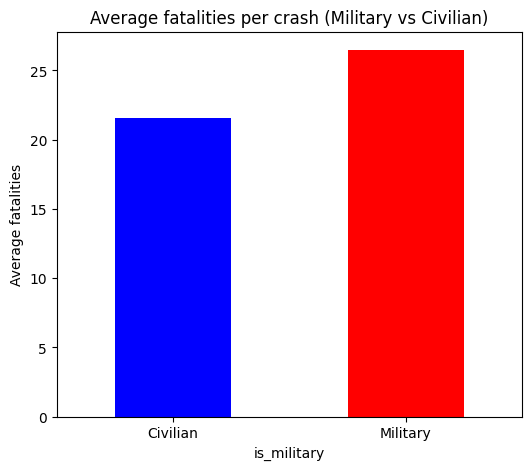

In [161]:
fatality_compare = df.groupby("is_military")["fatalities"].mean()

plt.figure(figsize=(6,5))
fatality_compare.plot(kind="bar", color=["blue", "red"])
plt.title("Average fatalities per crash (Military vs Civilian)")
plt.xticks([0,1], ["Civilian", "Military"], rotation=0)
plt.ylabel("Average fatalities")
plt.show()

- Military crashes have a slightly higher average fatality count per incident (approx. 26) compared to Civilian crashes (approx. 22).

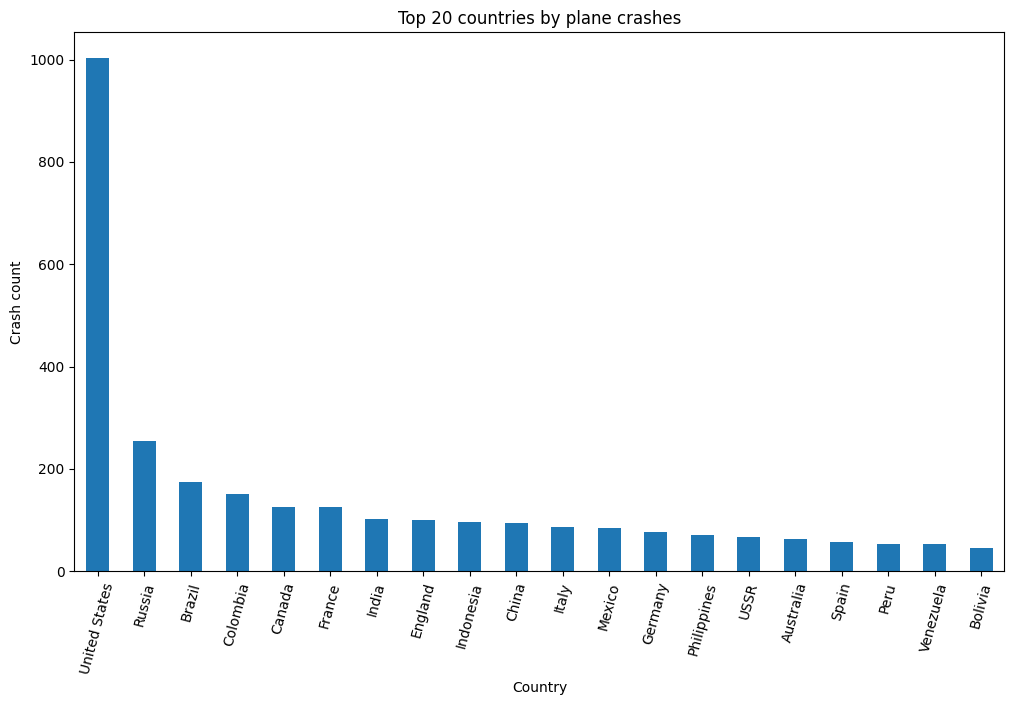

In [166]:
crashes_by_country = df["country"].value_counts().head(20)

plt.figure(figsize=(12,7))
crashes_by_country.plot(kind="bar")
plt.title("Top 20 countries by plane crashes")
plt.xlabel("Country")
plt.ylabel("Crash count")
plt.xticks(rotation=75)
plt.show()

- The United States leads overwhelmingly in the total number of crashes (around 1,000), which is likely a reflection of its high volume of total flight operations over the analyzed time period.

C:\Users\orucz\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


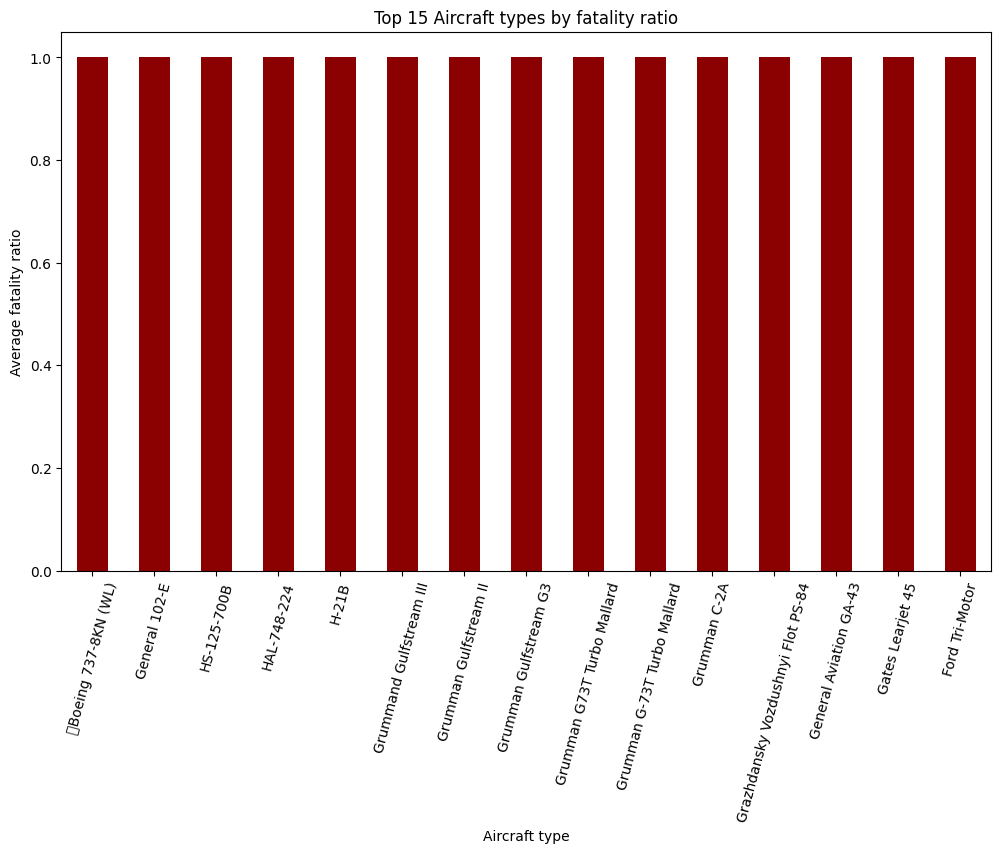

In [163]:
aircraft_fatality = df.groupby("aircraft_type")["fatality_ratio"].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,7))
aircraft_fatality.plot(kind="bar", color="darkred")
plt.title("Top 15 Aircraft types by fatality ratio")
plt.xlabel("Aircraft type")
plt.ylabel("Average fatality ratio")
plt.xticks(rotation=75)
plt.show()

- All aircraft listed have an average fatality ratio of 1.0 (100%), indicating that every recorded crash for these specific types resulted in zero survivors.

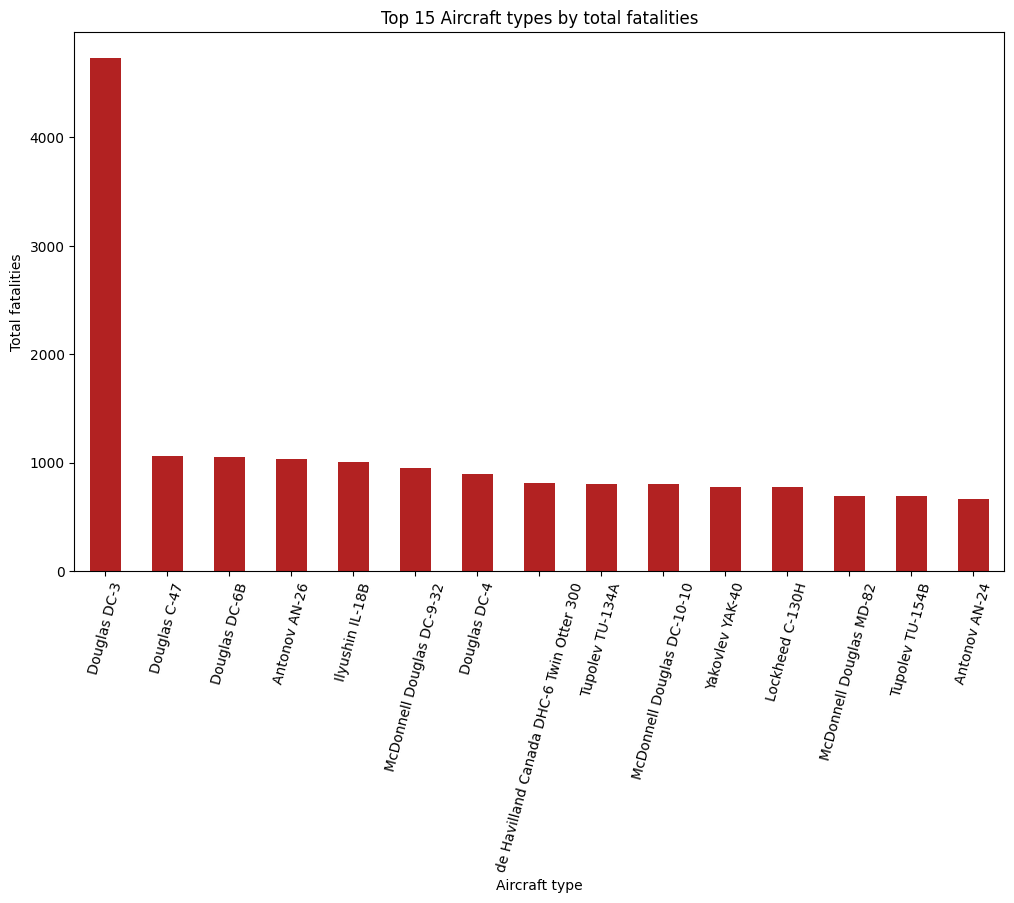

In [164]:
aircraft_total_fatalities = (
    df.groupby("aircraft_type")["fatalities"]
      .sum()
      .sort_values(ascending=False)
      .head(15)
)

plt.figure(figsize=(12,7))
aircraft_total_fatalities.plot(kind="bar", color="firebrick")
plt.title("Top 15 Aircraft types by total fatalities")
plt.xlabel("Aircraft type")
plt.ylabel("Total fatalities")
plt.xticks(rotation=75)
plt.show()

- The Douglas DC-3 is responsible for the highest number of total fatalities by a large margin (over 4,500), reflecting its long service life and heavy use during the mid-20th century when safety was lower.

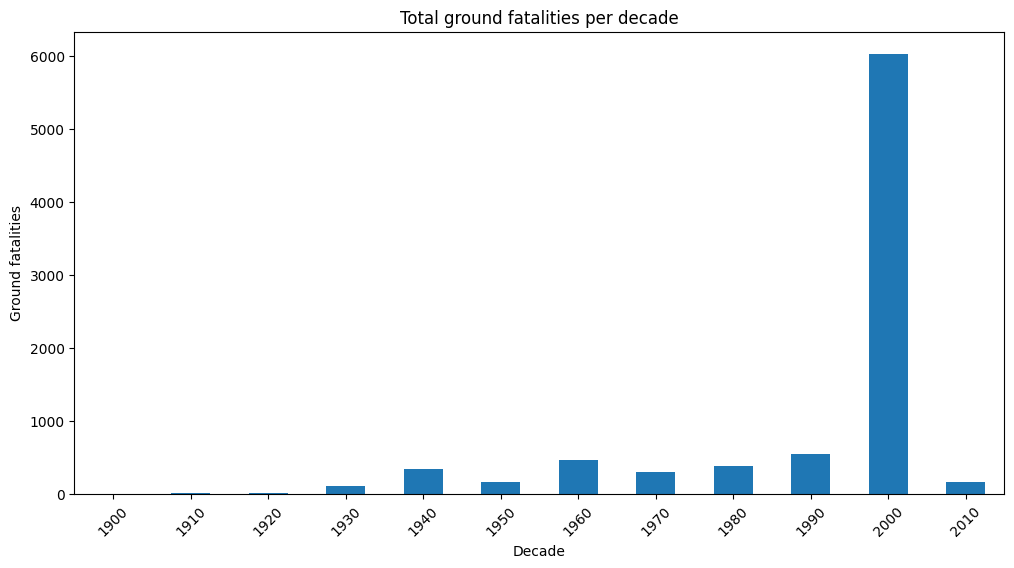

In [165]:
ground_decade = df.groupby("decade")["ground"].sum()

plt.figure(figsize=(12,6))
ground_decade.plot(kind="bar")
plt.title("Total ground fatalities per decade")
plt.xlabel("Decade")
plt.ylabel("Ground fatalities")
plt.xticks(rotation=45)
plt.show()

- Ground fatalities are generally very low across aviation history, except for an unprecedented, massive spike exceeding 6,000 in the 2000s. This spike is strongly attributed to the September 11, 2001, terrorist attacks, which resulted in the highest non-occupant casualty count in aviation history.

# Summary & Conclusion

The analysis reveals three major outcomes in aviation safety history:

- Improved Accident Prevention – The number of plane crashes has significantly decreased since the early 2000s. Modern aviation has brought crash frequencies down to levels not seen since the 1930s, demonstrating the effectiveness of safety programs and regulations.

- High Lethality of Crashes – While accidents have become less frequent, they remain extremely dangerous. The average fatality ratio across decades is consistently high, with over 80% of people onboard perishing in major crashes. Survival rates have improved slightly but remain low relative to total fatalities.

- Impact of Historical and Rare Events – The distribution of crashes and fatalities is heavily influenced by both geography and exceptional events. The United States, as a global aviation hub, accounts for the largest number of recorded crashes. Older aircraft, such as the Douglas DC-3, contributed to high cumulative fatalities due to extensive use and lower safety standards. Rare, catastrophic events, like the September 11 attacks in 2001, create extreme outliers in ground fatalities and underscore how singular events can dramatically affect long-term statistics.

- Overall Insight: Modern aviation is markedly safer, with far fewer accidents than in the past. However, when accidents do occur, they remain highly lethal. Understanding these trends helps contextualize aviation risk, emphasizing the importance of safety programs and preparedness for rare, high-impact events.